In [1]:
import sys
sys.path.append('..\\..')

In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.0.0'

In [5]:
dataset_name = 'mnist'

In [6]:
import tensorflow_datasets as tfds

info = tfds.builder(dataset_name).info

print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [7]:
intermediate_dim = 20
inputs_shape=(28, 28, 1) # image shape
batch_size = 100
latent_dim = 50

In [8]:
TRAIN_BUF = 600
TEST_BUF = 100


In [9]:
import tensorflow_datasets as tfds
# Construct a tf.data.Dataset
train_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TRAIN_BUF).batch(batch_size)
try:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TEST).shuffle(TEST_BUF).batch(batch_size)
except:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TEST_BUF).batch(batch_size)


In [10]:
_instance_scale=1.0
for data in train_ds:
    _instance_scale = float(data['image'][0].numpy().max())
    break

In [11]:
_instance_scale

255.0

In [12]:
enc_lays2 = [
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latent_dim)
]

dec_lays2 = [
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    
    # No activation
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
]

In [13]:
enc_mean_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

enc_var_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

dec_lays = [tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu')]

## First Time

In [14]:
#from utils.data_and_files.file_utils import make_random_string
#from time import gmtime, strftime

#model_name = 'AE_' + make_random_string(5) + strftime("%a_%d_%b_%Y_%H_%M", gmtime())
#print(model_name)

In [15]:
model_name = dataset_name+'AE'

In [16]:
recoding_dir='..\\..\\recoding\\'+model_name

In [17]:
import os

In [18]:
os.path.join(recoding_dir, model_name)

'..\\recoding\\mnistAE\\mnistAE'

In [19]:
from training.autoencoders.AE import AE

Using TensorFlow backend.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [20]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers': enc_mean_lays
    }

    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latent_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays
    }
]

In [21]:
_restore = os.path.join(recoding_dir, 'var_save_dir')

In [22]:
_restore

'..\\recoding\\mnistAE\\var_save_dir'

In [23]:
ae = AE( 
    model_name=model_name,
    inputs_shape=inputs_shape,
    outputs_shape=inputs_shape,
    latent_dim=latent_dim,
    variables_params=variables_params, 
    restore=None
    )

Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 28, 28, 20)        40        
_________________________________________________________________
dense_3 (Dense)              (None, 28, 28, 20)        420       
_________________________________________________________________
dense_4 (Dense)              (None, 28, 28, 20)        420       
_________________________________________________________________
flatten_1 (Flatten)          (None, 15680)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                784050    
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0 

  WARNING  | None


Model: "generative"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_9 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_10 (Dense)             (None, 40)                1640      
_________________________________________________________________
flatten_2 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               32144     
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0

  WARNING  | None


In [24]:
import numpy as np
n_generated = 50
random_latent = np.random.normal(size=[n_generated, latent_dim])
#np.save(file='random_latent.npy', arr=random_latent)
#random_latent = tf.constant(np.load(file='..\\data\\random_latent.npy'))

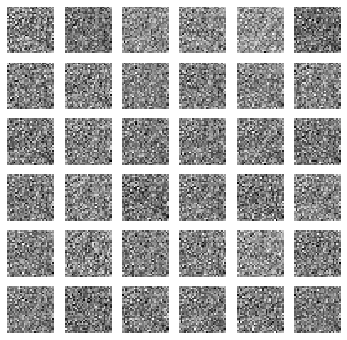

  ERROR    | No former training found ... 
Epochs Progress:   0%|                                                                          | 0/10 [00:00<?, ?it/s]

  INFO     | Training ... 
Epochs Progress, Training Iterations 5:   0%|                                                   | 0/10 [00:17<?, ?it/s]

KeyboardInterrupt: 

In [25]:
ae.fit(
    train_dataset=train_ds, 
    test_dataset=test_ds,
    instance_names=['image'],
    epochs=10,
    learning_rate=1e-3,
    random_latent=random_latent,
    recoding_dir=recoding_dir,
    gray_plot=True,
    generate_epoch=5,
    save_epoch=5,
    metric_epoch=10,
    gt_data=None
)

In [26]:
#from ground_truth_datasets.datasets import load

In [27]:
for batch in train_ds:
    image = batch['image'].numpy()[0]
    break

In [28]:
import matplotlib.pyplot as plt

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (arialbd.ttf) normal normal bold normal>) = 6.698636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (ARIALN.TTF) normal normal 400 condensed>) = 6.613636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Elephant' (ELEPHNT.TTF) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe Script' (segoesc.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Niagara Solid' (NIAGSOL.TTF) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Book An

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Snap ITC' (SNAP____.TTF) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MS Reference Specialty' (REFSPCL.TTF) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI' (seguibl.ttf) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Calibri' (calibrib.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sitka Small' (SitkaI.ttc)

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate Gothic Bold' (COPRGTB.TTF) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'High Tower Text' (HTOWERTI.TTF) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (ARIALNBI.TTF) italic normal bold condensed>) = 7.8986363636363635
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Sans Typewriter' (LTYPE.TTF) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_ma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (arialbi.ttf) italic normal bold normal>) = 7.698636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gill Sans MT Condensed' (GILC____.TTF) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Fax' (LFAXI.TTF) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal semibold normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (symbol.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chiller' 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tw Cen MT' (TCM_____.TTF) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Leelawadee UI' (LeelawUI.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ju

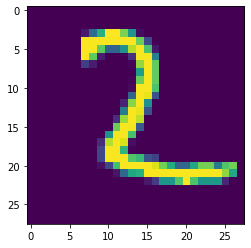

In [29]:
plt.imshow(image.reshape(28,28))

In [30]:
reconst = ae.decode(ae.encode(image))

C:\Anaconda\envs\tf\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Anaconda\envs\tf\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Anaconda\envs\tf\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Anaconda\envs\tf\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Anaconda\envs\tf\lib\site-packages\numpy\ma\core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


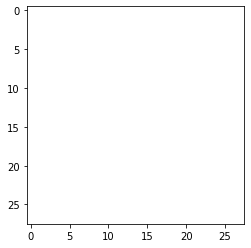

In [31]:
plt.imshow(reconst.numpy().reshape(28,28))